In [2]:
# load libraries

import nilearn.plotting as plotting
import nilearn.image as image
from nilearn import datasets
import nibabel as nib
import matplotlib.pyplot as plt


In [24]:
# Load the image with nibabel
atlas_img = nib.load(msdl_atlas_img)

# Save it as a NIfTI file
nib.save(atlas_img, 'msdl_atlas.nii.gz')

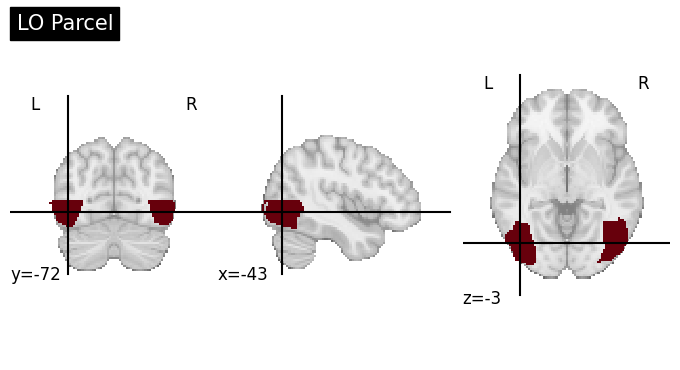

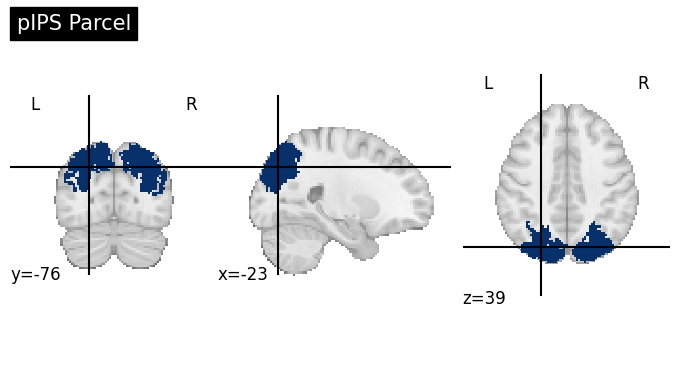

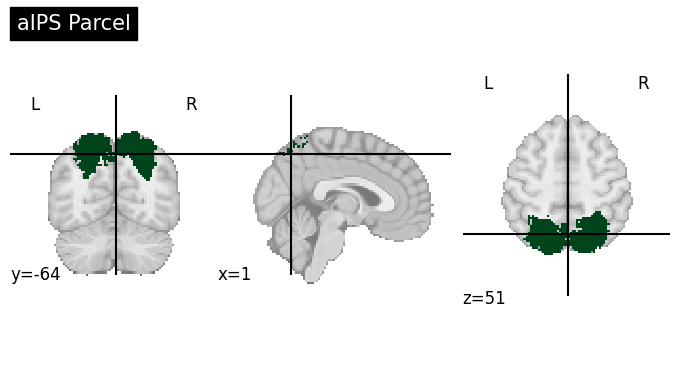

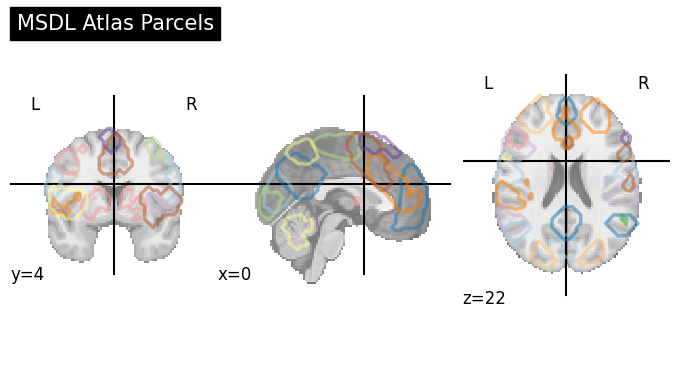

In [21]:
from nilearn import plotting, datasets
import nibabel as nib

# Load each parcel
parcel_lo = nib.load('roiParcels/LO.nii.gz')
parcel_pips = nib.load('roiParcels/pIPS.nii.gz')
parcel_aips = nib.load('roiParcels/aIPS.nii.gz')

# Plot each Julian/Mruczek parcel with colors
plotting.plot_stat_map(parcel_lo, title="LO Parcel", colorbar=False, cmap='Reds', threshold=0.1)
plotting.plot_stat_map(parcel_pips, title="pIPS Parcel", colorbar=False, cmap='Blues', threshold=0.1)
plotting.plot_stat_map(parcel_aips, title="aIPS Parcel", colorbar=False, cmap='Greens', threshold=0.1)

# Load and plot all MSDL atlas parcels
msdl_atlas = datasets.fetch_atlas_msdl()
msdl_atlas_img = msdl_atlas['maps']
plotting.plot_prob_atlas(msdl_atlas_img, title="MSDL Atlas Parcels", cmap="Paired", alpha=0.5)

plotting.show()


2024-11-14 17:53:01,279 - INFO - Saved mapping to /user_data/csimmon2/git_repos/ptoc/results/visual_parcels_mapping/visual_parcels_to_schaefer_mapping.csv
2024-11-14 17:53:01,287 - INFO - Plotting original parcels...


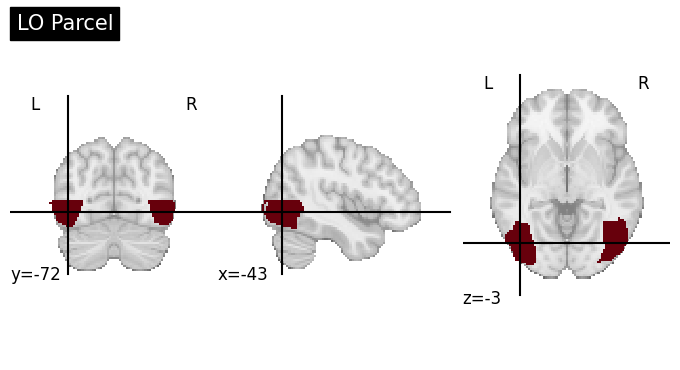

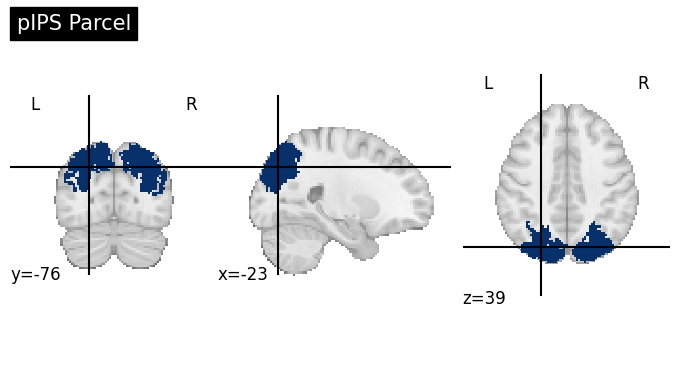

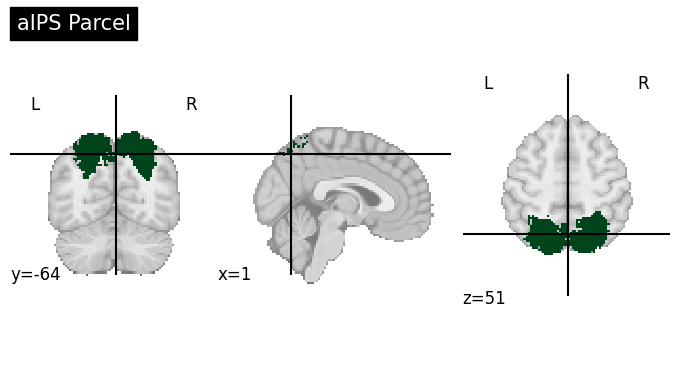

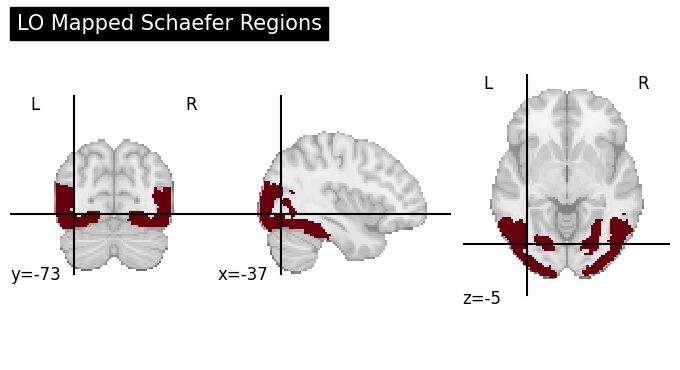

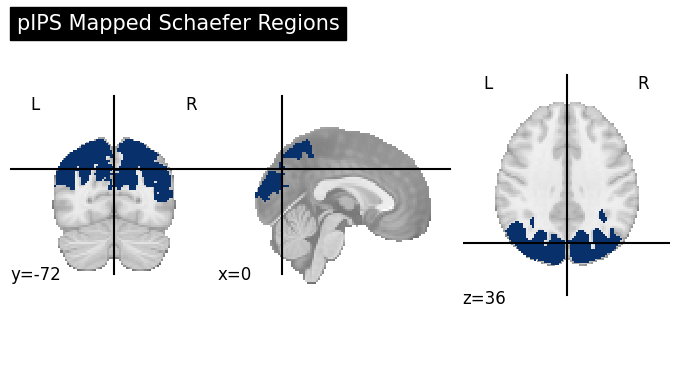

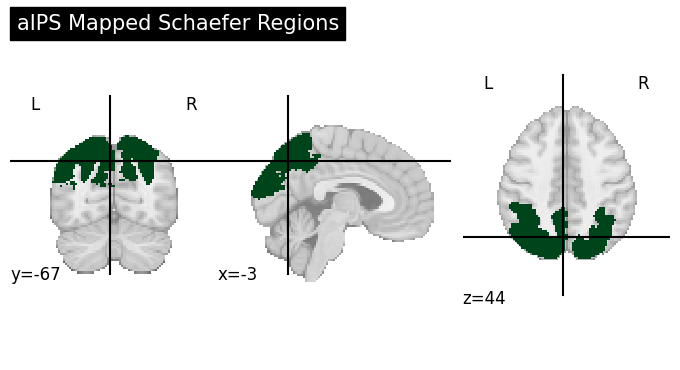

In [7]:
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import plotting, datasets
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

def load_visual_parcels():
    """Load the Mruczek/Julian parcels"""
    parcels = {
        'LO': nib.load('roiParcels/LO.nii.gz'),
        'pIPS': nib.load('roiParcels/pIPS.nii.gz'),
        'aIPS': nib.load('roiParcels/aIPS.nii.gz')
    }
    return parcels

def find_overlapping_regions(parcel_img, atlas_img, atlas_labels, overlap_threshold=0.1):
    """
    Find Schaefer regions that overlap with a given parcel
    
    Parameters:
    -----------
    parcel_img : nibabel.Nifti1Image
        The parcel image
    atlas_img : nibabel.Nifti1Image
        The Schaefer atlas image
    atlas_labels : list
        List of Schaefer region labels
    overlap_threshold : float
        Minimum overlap fraction to consider (0-1)
        
    Returns:
    --------
    list of dicts
        Each dict contains region index, name, and overlap percentage
    """
    parcel_data = parcel_img.get_fdata()
    atlas_data = atlas_img.get_fdata()
    
    # Get parcel voxels
    parcel_voxels = parcel_data > 0
    parcel_volume = np.sum(parcel_voxels)
    
    overlapping_regions = []
    
    # Check each atlas region
    for i, label in enumerate(atlas_labels):
        if i == 0:  # Skip background
            continue
            
        # Get atlas region voxels
        region_voxels = atlas_data == i
        
        # Calculate overlap
        overlap_voxels = np.sum(np.logical_and(parcel_voxels, region_voxels))
        if overlap_voxels > 0:
            overlap_percentage = (overlap_voxels / parcel_volume) * 100
            
            if overlap_percentage >= overlap_threshold:
                overlapping_regions.append({
                    'region_index': i,
                    'region_name': label,
                    'overlap_percentage': overlap_percentage
                })
    
    return overlapping_regions

def create_mapping(n_rois=200):
    """Create mapping between visual parcels and Schaefer atlas"""
    # Load atlases
    visual_parcels = load_visual_parcels()
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
    schaefer_img = nib.load(schaefer.maps)
    
    # Create mapping
    mapping = []
    for parcel_name, parcel_img in visual_parcels.items():
        overlapping = find_overlapping_regions(parcel_img, schaefer_img, schaefer.labels)
        
        for region in overlapping:
            mapping.append({
                'visual_parcel': parcel_name,
                'schaefer_index': region['region_index'],
                'schaefer_region': region['region_name'],
                'overlap_percentage': region['overlap_percentage']
            })
    
    return pd.DataFrame(mapping)

def plot_mapping_results():
    """Plot original parcels and their Schaefer mappings"""
    # Load parcels
    parcels = load_visual_parcels()
    
    # Plot original parcels
    logging.info("Plotting original parcels...")
    plotting.plot_stat_map(
        parcels['LO'],
        title="LO Parcel",
        colorbar=False,
        cmap='Reds',
        threshold=0.1,
        display_mode='ortho'
    )
    
    plotting.plot_stat_map(
        parcels['pIPS'],
        title="pIPS Parcel",
        colorbar=False,
        cmap='Blues',
        threshold=0.1,
        display_mode='ortho'
    )
    
    plotting.plot_stat_map(
        parcels['aIPS'],
        title="aIPS Parcel",
        colorbar=False,
        cmap='Greens',
        threshold=0.1,
        display_mode='ortho'
    )
    
    # Get mapping
    mapping_df = create_mapping()
    
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    schaefer_img = nib.load(schaefer.maps)
    
    # Create masked Schaefer images for each parcel
    for parcel_name in ['LO', 'pIPS', 'aIPS']:
        # Get indices for this parcel
        parcel_regions = mapping_df[mapping_df['visual_parcel'] == parcel_name]['schaefer_index'].values
        
        if len(parcel_regions) > 0:
            # Create masked image
            mask = np.zeros_like(schaefer_img.get_fdata())
            for idx in parcel_regions:
                mask[schaefer_img.get_fdata() == idx] = 1
                
            masked_img = nib.Nifti1Image(mask, schaefer_img.affine)
            
            # Plot
            cmap = 'Reds' if parcel_name == 'LO' else 'Blues' if parcel_name == 'pIPS' else 'Greens'
            plotting.plot_stat_map(
                masked_img,
                title=f"{parcel_name} Mapped Schaefer Regions",
                colorbar=False,
                cmap=cmap,
                threshold=0.1,
                display_mode='ortho'
            )

def main():
    # Create output directory
    output_dir = f'{results_dir}/visual_parcels_mapping'
    os.makedirs(output_dir, exist_ok=True)
    
    # Create mapping
    mapping_df = create_mapping()
    
    # Save mapping
    mapping_df.to_csv(f'{output_dir}/visual_parcels_to_schaefer_mapping.csv', index=False)
    logging.info(f"Saved mapping to {output_dir}/visual_parcels_to_schaefer_mapping.csv")
    
    # Plot results
    plot_mapping_results()
    plotting.show()

if __name__ == "__main__":
    main()

In [7]:
# generate schaefer 200 roi list || compared to visual parcels

import nibabel as nib
import numpy as np
from nilearn import datasets
import pandas as pd

def get_schaefer_rois(parcel_path):
    """Get Schaefer 200 ROIs that overlap with a given parcel"""
    # Load the parcel
    parcel_img = nib.load(parcel_path)
    parcel_data = parcel_img.get_fdata()
    parcel_volume = np.sum(parcel_data > 0)
    
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(schaefer.maps)
    atlas_data = atlas_img.get_fdata()
    
    # Find overlapping ROIs
    overlapping_rois = []
    covered_voxels = set()
    parcel_coords = set(map(tuple, np.array(np.where(parcel_data > 0)).T))
    
    # Check each ROI
    for i in range(1, 201):  # Schaefer 200 ROIs
        roi_mask = atlas_data == i
        intersection = np.logical_and(parcel_data > 0, roi_mask)
        
        if np.any(intersection):
            intersection_volume = np.sum(intersection)
            overlap_percentage = intersection_volume / parcel_volume
            
            roi_coords = set(map(tuple, np.array(np.where(roi_mask)).T))
            new_coverage = roi_coords.intersection(parcel_coords) - covered_voxels
            unique_coverage = len(new_coverage) / parcel_volume
            
            if unique_coverage >= 0.005:  # At least 0.5% new coverage
                covered_voxels.update(new_coverage)
                overlapping_rois.append({
                    'roi_index': i-1,  # Convert to 0-based for connectivity matrices
                    'roi_name': schaefer.labels[i-1].decode(),
                    'network': schaefer.labels[i-1].decode().split('_')[2],
                    'overlap_percentage': overlap_percentage * 100,
                    'unique_coverage': unique_coverage * 100
                })
    
    # Sort by overlap percentage
    overlapping_rois.sort(key=lambda x: x['overlap_percentage'], reverse=True)
    return overlapping_rois

def main():
    parcels = {
        'LO': 'roiParcels/LO.nii.gz',
        'pIPS': 'roiParcels/pIPS.nii.gz',
        'aIPS': 'roiParcels/aIPS.nii.gz',
        'PFS': 'roiParcels/PFS.nii.gz',
    }
    
    # Store all results
    all_results = []
    
    print("\nDetailed ROI List for Each Parcel:")
    print("=" * 80)
    
    for parcel_name, parcel_path in parcels.items():
        print(f"\n{parcel_name} Parcel ROIs:")
        print("-" * 40)
        
        rois = get_schaefer_rois(parcel_path)
        
        # Group ROIs by network
        network_rois = {}
        for roi in rois:
            network = roi['network']
            if network not in network_rois:
                network_rois[network] = []
            network_rois[network].append(roi)
        
        # Print results grouped by network
        for network, network_rois_list in network_rois.items():
            print(f"\n{network} Network:")
            for roi in network_rois_list:
                print(f"Index {roi['roi_index']}: {roi['roi_name']}")
                print(f"  Overlap: {roi['overlap_percentage']:.1f}%")
                print(f"  Unique Coverage: {roi['unique_coverage']:.1f}%")
        
        # Add to overall results
        for roi in rois:
            roi['parcel'] = parcel_name
            all_results.append(roi)
        
        # Print summary
        total_coverage = sum(roi['unique_coverage'] for roi in rois)
        print(f"\nTotal ROIs for {parcel_name}: {len(rois)}")
        print(f"Total Coverage: {total_coverage:.1f}%")
        
        # Print indices in a format easy to copy for numpy indexing
        indices = [roi['roi_index'] for roi in rois]
        print("\nROI indices for connectivity matrices:")
        print(f"indices_{parcel_name.lower()} = [{', '.join(map(str, indices))}]")
    
    # Save to CSV
    df = pd.DataFrame(all_results)
    df.to_csv('schaefer200_roi_mapping_detailed.csv', index=False)
    
    # Create a more concise summary DataFrame
    summary = []
    for parcel_name in parcels.keys():
        parcel_rois = [r for r in all_results if r['parcel'] == parcel_name]
        networks = set(r['network'] for r in parcel_rois)
        
        for network in networks:
            network_rois = [r for r in parcel_rois if r['network'] == network]
            network_coverage = sum(r['unique_coverage'] for r in network_rois)
            
            summary.append({
                'parcel': parcel_name,
                'network': network,
                'n_rois': len(network_rois),
                'coverage': network_coverage
            })
    
    summary_df = pd.DataFrame(summary)
    print("\nNetwork Coverage Summary:")
    print(summary_df.to_string())
    summary_df.to_csv('schaefer200_network_summary.csv', index=False)

if __name__ == "__main__":
    main()


Detailed ROI List for Each Parcel:

LO Parcel ROIs:
----------------------------------------

Vis Network:
Index 2: 7Networks_LH_Vis_3
  Overlap: 15.4%
  Unique Coverage: 15.4%
Index 104: 7Networks_RH_Vis_5
  Overlap: 14.4%
  Unique Coverage: 14.4%
Index 7: 7Networks_LH_Vis_8
  Overlap: 5.5%
  Unique Coverage: 5.5%
Index 10: 7Networks_LH_Vis_11
  Overlap: 4.5%
  Unique Coverage: 4.5%
Index 110: 7Networks_RH_Vis_11
  Overlap: 3.2%
  Unique Coverage: 3.2%
Index 107: 7Networks_RH_Vis_8
  Overlap: 3.0%
  Unique Coverage: 3.0%
Index 1: 7Networks_LH_Vis_2
  Overlap: 2.9%
  Unique Coverage: 2.9%
Index 102: 7Networks_RH_Vis_3
  Overlap: 2.7%
  Unique Coverage: 2.7%
Index 4: 7Networks_LH_Vis_5
  Overlap: 2.1%
  Unique Coverage: 2.1%
Index 8: 7Networks_LH_Vis_9
  Overlap: 1.6%
  Unique Coverage: 1.6%

DorsAttn Network:
Index 134: 7Networks_RH_DorsAttn_Post_1
  Overlap: 7.2%
  Unique Coverage: 7.2%
Index 135: 7Networks_RH_DorsAttn_Post_2
  Overlap: 6.8%
  Unique Coverage: 6.8%
Index 31: 7Network

Processing LO...


/tmp/ipykernel_26965/2058471365.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Completed LO
Processing pIPS...
Completed pIPS
Processing aIPS...
Completed aIPS
Processing PFS...
Completed PFS


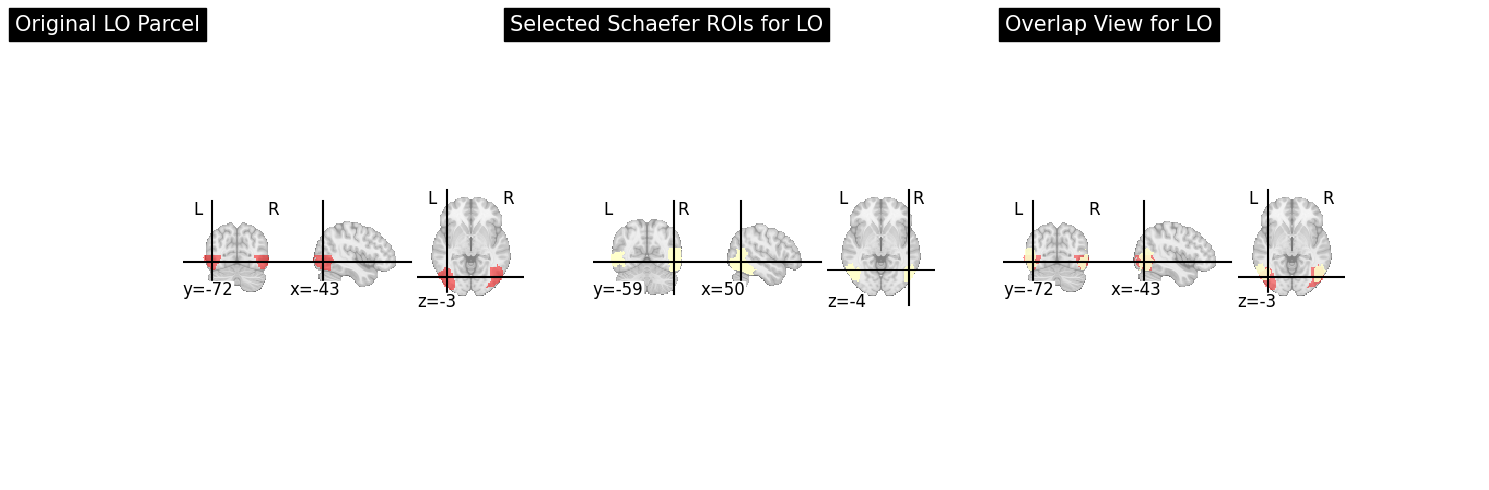

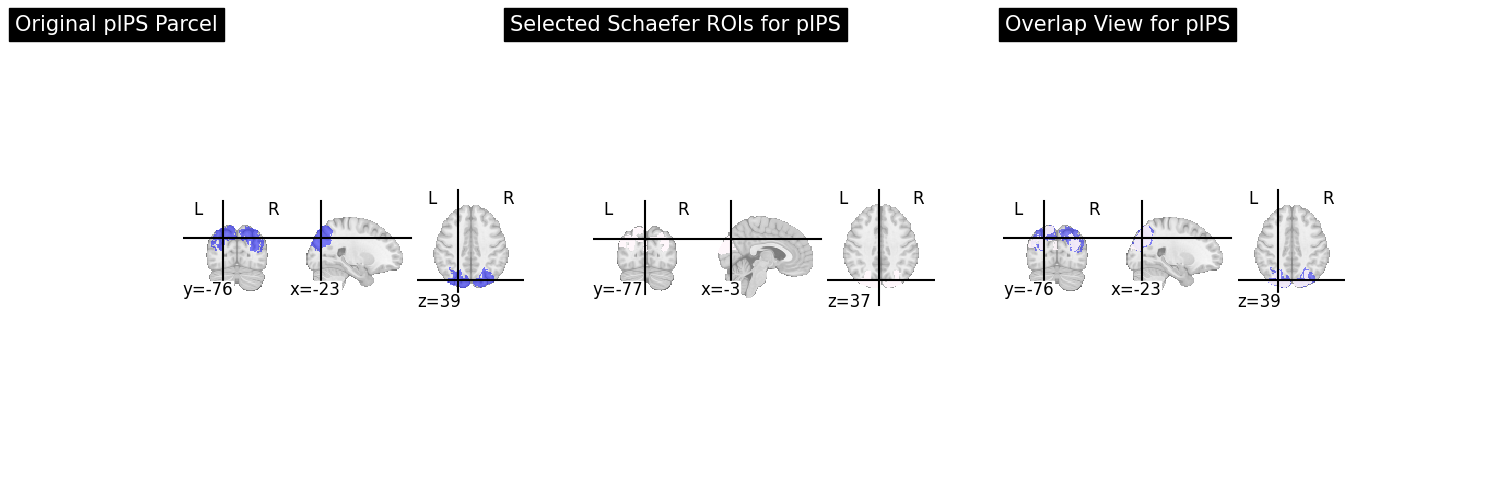

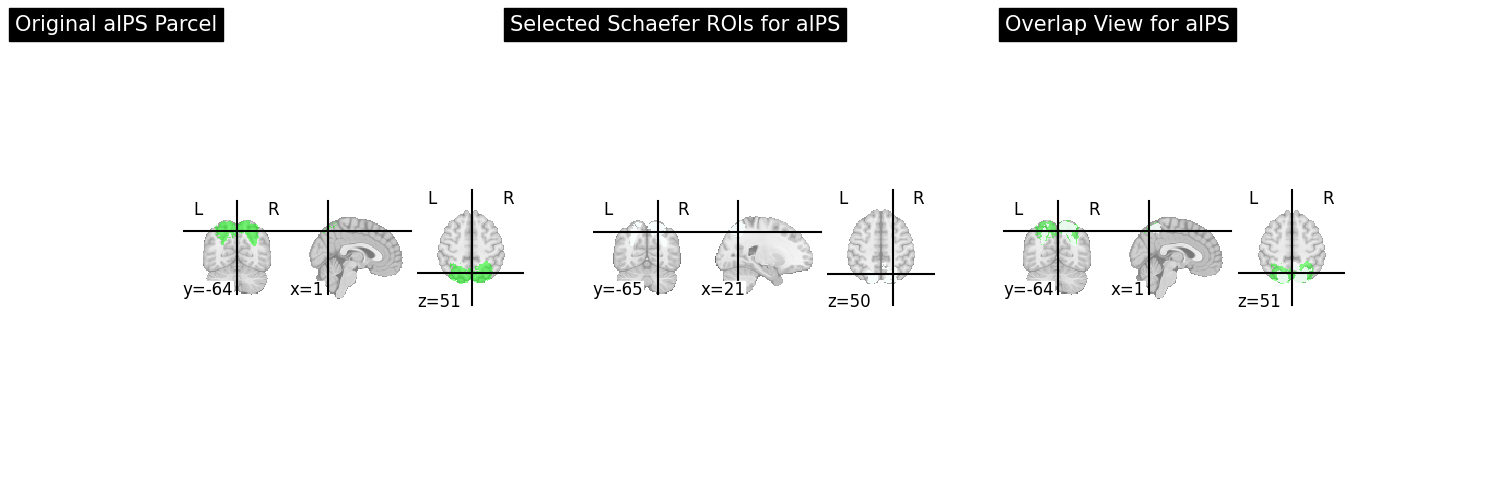

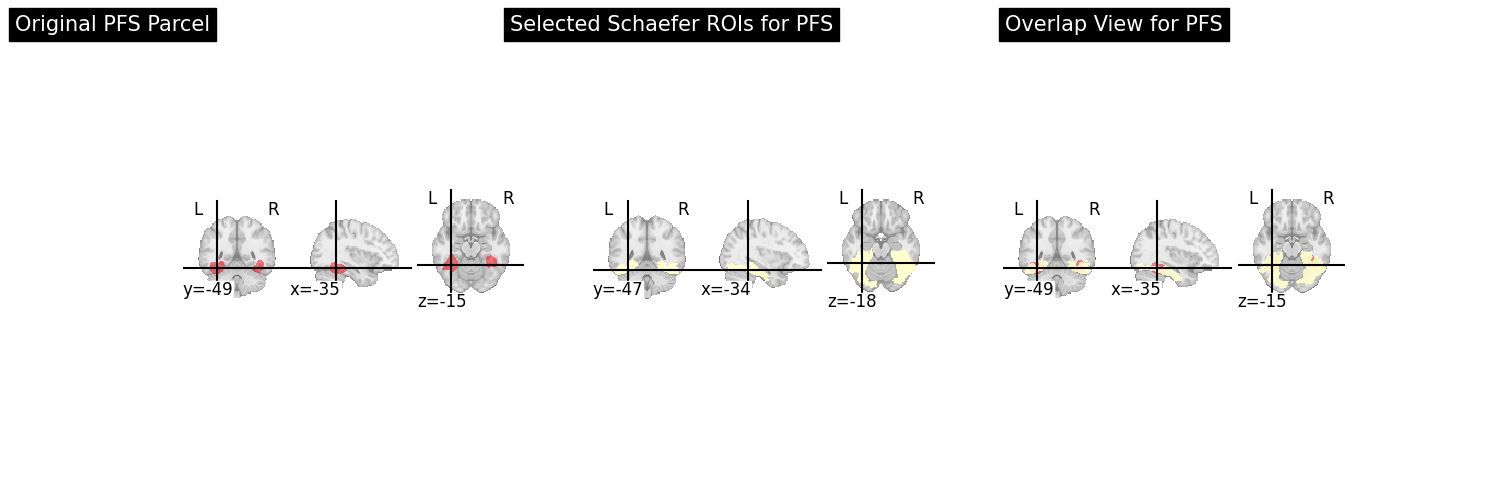

In [ ]:
# visualizing selected ROIs

import nibabel as nib
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_orange_transparent_cmap():
    """Create a custom orange transparent colormap"""
    colors = [(1, 1, 1, 0), (1, 0.5, 0, 1)]  # White (transparent) to orange
    return LinearSegmentedColormap.from_list('orange_transparent', colors, N=256)

def create_selected_schaefer_mask(selected_indices, schaefer_img):
    """Create a mask of only the selected Schaefer ROIs"""
    schaefer_data = schaefer_img.get_fdata()
    mask = np.zeros_like(schaefer_data)
    
    for idx in selected_indices:
        mask[schaefer_data == (idx + 1)] = 1
    
    return nib.Nifti1Image(mask, schaefer_img.affine)

def visualize_single_parcel(parcel_name, parcel_info, schaefer_img, view_type='basic'):
    """Visualize a single parcel with its corresponding Schaefer ROIs"""
    # Load parcel
    parcel_img = nib.load(parcel_info['file'])
    
    # Create mask of selected Schaefer ROIs
    selected_rois = create_selected_schaefer_mask(parcel_info['indices'], schaefer_img)
    
    # Define color mappings - using only standard colormaps
    color_maps = {
        'LO': {'transparent': plotting.cm.red_transparent, 'solid': 'YlOrRd'},
        'pIPS': {'transparent': plotting.cm.blue_transparent, 'solid': 'PuBu'},
        'aIPS': {'transparent': plotting.cm.green_transparent, 'solid': 'BuGn'},
        'PFS': {'transparent': plotting.cm.red_transparent, 'solid': 'YlOrRd'}  # Reusing red colormap
    }
    
    if view_type == 'basic':
        fig = plt.figure(figsize=(15, 5))
        
        # Plot original parcel
        ax1 = plt.subplot(131)
        plotting.plot_roi(
            parcel_img,
            title=f"Original {parcel_name} Parcel",
            colorbar=False,
            cmap=color_maps[parcel_name]['transparent'],
            alpha=1.0,  # Increased opacity
            axes=ax1
        )
        
        # Plot selected Schaefer ROIs
        ax2 = plt.subplot(132)
        plotting.plot_roi(
            selected_rois,
            title=f"Selected Schaefer ROIs for {parcel_name}",
            colorbar=False,
            cmap=color_maps[parcel_name]['solid'],
            alpha=1.0,  # Increased opacity
            axes=ax2
        )
        
        # Plot overlap
        ax3 = plt.subplot(133)
        display = plotting.plot_roi(
            parcel_img,
            title=f"Overlap View for {parcel_name}",
            colorbar=False,
            cmap=color_maps[parcel_name]['transparent'],
            alpha=0.9,
            axes=ax3
        )
        display.add_overlay(
            selected_rois,
            cmap=color_maps[parcel_name]['solid'],
            alpha=0.9
        )
        
        plt.tight_layout()
        plt.savefig(f'{parcel_name}_schaefer_overlap.png', dpi=300, bbox_inches='tight')
        #plt.close()

# Rest of the code remains the same, including the parcels dictionary with all indices
parcels = {
    'LO': {'file': 'roiParcels/LO.nii.gz', 'color': 'Reds', 'indices': [2, 104, 134, 135, 7, 31]},
    'pIPS': {'file': 'roiParcels/pIPS.nii.gz', 'color': 'Blues', 'indices': [114, 36, 32, 13, 79, 141, 12, 113]},
    'aIPS': {'file': 'roiParcels/aIPS.nii.gz', 'color': 'Greens', 'indices': [141, 36, 114, 32, 142, 139]},
    'PFS': {'file': 'roiParcels/PFS.nii.gz', 'color': 'Reds', 'indices': [30, 100, 134, 0, 101, 99, 1, 102, 57]}
}

def visualize_overlap(parcels_to_process=None, view_type='basic'):
    """Main function to visualize ROI overlaps"""
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    schaefer_img = nib.load(schaefer.maps)
    
    # Define parcels with the full set of indices for PFS
    parcels = {
        'LO': {'file': 'roiParcels/LO.nii.gz', 'color': 'Reds', 'indices': [2, 104, 134, 135, 7, 31]},
        'pIPS': {'file': 'roiParcels/pIPS.nii.gz', 'color': 'Blues', 'indices': [114, 36, 32, 13, 79, 141, 12, 113]},
        'aIPS': {'file': 'roiParcels/aIPS.nii.gz', 'color': 'Greens', 'indices': [141, 36, 114, 32, 142, 139]},
        'PFS': {'file': 'roiParcels/PFS.nii.gz', 'color': 'YlOrBr', 'indices': [30, 100, 134, 0, 101, 99, 1, 102, 57]}
    }
    
    # Determine which parcels to process
    if parcels_to_process is None:
        parcels_to_process = parcels.keys()
    
    # Process each parcel
    for parcel_name in parcels_to_process:
        if parcel_name in parcels:
            print(f"Processing {parcel_name}...")
            visualize_single_parcel(parcel_name, parcels[parcel_name], schaefer_img, view_type)
            print(f"Completed {parcel_name}")
        else:
            print(f"Warning: {parcel_name} not found in defined parcels")

if __name__ == "__main__":
    # Process all parcels
    visualize_overlap() #runs all parcels